# section5

## 次元削減でデータを圧縮する

- 教師なしデータ圧縮での主成分分析(PCA)
- クラス分離を最大化する教師あり次元削減法としての線形判別分析(LDA)
- カーネル主成分分析(KPCA)による非線形次元削減

In [12]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

# if the Wine dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df_wine = pd.read_csv('wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [13]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                     stratify=y,
                     random_state=0)

In [14]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)


### np.cov　共分散の計算
### np.linalg.eig(共分散行列)　固有値と固有ベクトルの計算
### np.linalg.eigh(共分散行列)　こちらのほうが安定した数値が得られる

In [15]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


### np.sumsum()　累積和の取得
### plt.step()　階段グラフの作成（累積和の表示などによい）

In [16]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

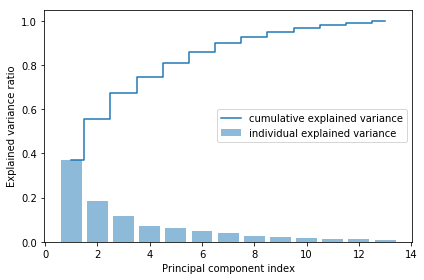

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/05_02.png', dpi=300)
plt.show()

In [18]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [19]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print(w)

[[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [20]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

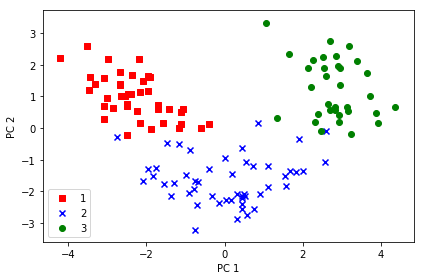

In [21]:
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_03.png', dpi=300)
plt.show()

In [50]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.6,
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx],
                    label=cl)

<function matplotlib.pyplot.show(*args, **kw)>

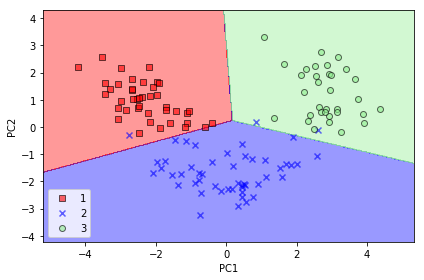

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
lr = LogisticRegression()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show

### from sklearn.decomposition import PCA
主成分分析

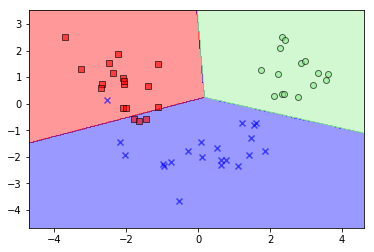

In [84]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.show()

In [85]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

### ☝分散説明率の計算
n_componebts=Noneに設定するのは次元削減する代わりにすべての主成分がソートされた状態で返されるようにするためである。

In [86]:
np.meshgrid()

[]

In [23]:
import numpy as np
a = np.arange(2, 10, 0.5)

In [24]:
a

array([2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ,
       8.5, 9. , 9.5])

メッシュグリッド
https://deepage.net/img/numpy/meshgrid/meshgrid-explanation.jpg

np.ravelは一次元配列に変換する

In [71]:
xx1, xx2 = np.meshgrid(np.arange(1, 100, 1),np.arange(1, 100, 1))

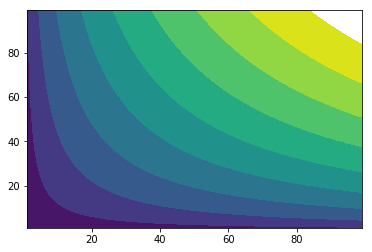

In [80]:
z = np.sqrt(xx1 * xx2)
plt.contourf(xx1, xx2, z, levels=np.arange(1, 100, 10))

### 線形判別分析（LDA）
特徴抽出手法の一つ。分離を最適化する特徴部分空間を見つけようとする。教師ありアルゴリズム。LDAのほうがPCAより優れている場合が多い。画像認識など各クラスのサンプルの個数がごく少ないときPCAのほうが結果が良くなることがある。

LDAはデータが正規分布に従っていて、クラスの共分散行列が同じ、特徴量が互いに独立であることを前提にしている。

In [102]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1,4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print(('MV %s: %s\n' %(label, mean_vecs[label-1])))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



In [91]:
np.shape(X_train_std)

(124, 13)

In [92]:
X_train_std

array([[ 0.7123,  2.2205, -0.1303, ..., -0.2002, -0.8216, -0.6295],
       [ 0.8823, -0.7046,  1.1753, ...,  1.3398,  0.5493,  1.4757],
       [ 0.8459, -0.7302,  1.1753, ...,  1.0681,  0.1308,  1.6293],
       ...,
       [ 1.028 ,  2.2975, -0.5779, ..., -1.6949, -1.8607, -1.0443],
       [-1.3038, -1.0809, -0.3168, ...,  0.1622,  0.7369,  0.4031],
       [-0.4051,  1.2968,  0.0563, ...,  1.0681,  0.7369, -0.8968]])

In [93]:
X_train[1]

array([1.376e+01, 1.530e+00, 2.700e+00, 1.950e+01, 1.320e+02, 2.950e+00,
       2.740e+00, 5.000e-01, 1.350e+00, 5.400e+00, 1.250e+00, 3.000e+00,
       1.235e+03])

In [101]:
np.mean(X_train[y_train==1], axis=0)

array([1.3780e+01, 1.9449e+00, 2.4707e+00, 1.7410e+01, 1.0620e+02,
       2.8663e+00, 3.0417e+00, 3.0122e-01, 1.9605e+00, 5.6415e+00,
       1.0844e+00, 3.0741e+00, 1.1477e+03])

In [108]:
d = 13
S_W = np.zeros((d, d))
np.shape(S_W)
for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
np.shape(S_W)

(13, 13)

In [111]:
np.bincount(y_train[1:])

array([ 0, 41, 50, 32], dtype=int64)

In [112]:
d = 13
S_W = np.zeros((d, d))
np.shape(S_W)
for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
np.shape(S_W)

(13, 13)

In [114]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
np.shape(S_B)

(13, 13)

In [115]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [119]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
eigen_pairs
for eigen_val in eigen_pairs:
    print(eigen_val[0])

349.6178089059939
172.76152218979388
3.7853134512521556e-14
2.117398448224407e-14
1.5164618894178885e-14
1.5164618894178885e-14
1.3579567140455979e-14
1.3579567140455979e-14
7.587760371654683e-15
5.906039984472233e-15
5.906039984472233e-15
2.256441978569674e-15
0.0


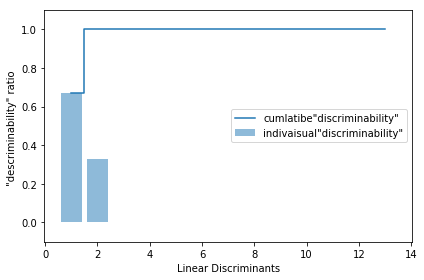

In [121]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='indivaisual"discriminability"')
plt.step(range(1, 14), cum_discr, where='mid', label='cumlatibe"discriminability"')
plt.ylabel('"descriminability" ratio ')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [132]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
           eigen_pairs[1][1][:, np.newaxis].real))
print('Mtrix W:\n', w)

Mtrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


In [133]:
eigen_pairs

[(349.6178089059939,
  array([-0.1481+0.j,  0.0908+0.j, -0.0168+0.j,  0.1484+0.j, -0.0163+0.j,
          0.1913+0.j, -0.7338+0.j, -0.075 +0.j,  0.0018+0.j,  0.294 +0.j,
         -0.0328+0.j, -0.3547+0.j, -0.3915+0.j])),
 (172.76152218979388,
  array([-0.4092+0.j, -0.1577+0.j, -0.3537+0.j,  0.3223+0.j, -0.0817+0.j,
          0.0842+0.j,  0.2823+0.j, -0.0102+0.j,  0.0907+0.j, -0.2152+0.j,
          0.2747+0.j, -0.0124+0.j, -0.5958+0.j])),
 (3.7853134512521556e-14,
  array([ 0.406 +0.j,  0.153 +0.j,  0.2157+0.j,  0.1153+0.j,  0.0043+0.j,
         -0.038 +0.j, -0.5208+0.j, -0.0864+0.j,  0.1421+0.j, -0.0811+0.j,
         -0.0103+0.j,  0.6254+0.j, -0.2319+0.j])),
 (2.117398448224407e-14,
  array([-0.5115+0.j, -0.1468+0.j,  0.0056+0.j, -0.1081+0.j, -0.1021+0.j,
          0.2103+0.j, -0.1468+0.j, -0.0279+0.j, -0.0711+0.j, -0.2123+0.j,
         -0.3724+0.j, -0.1993+0.j,  0.6322+0.j])),
 (1.5164618894178885e-14,
  array([-0.6795+0.j    ,  0.1224+0.0641j,  0.0873+0.0821j, -0.3026-0.0141j,
       

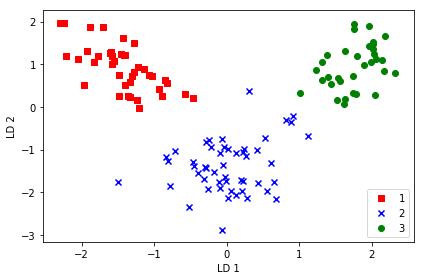

In [138]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [136]:
y_train

array([3, 1, 1, 1, 3, 2, 2, 3, 2, 2, 2, 1, 2, 3, 1, 3, 2, 1, 3, 3, 2, 1,
       2, 2, 2, 2, 3, 1, 2, 2, 1, 1, 3, 1, 2, 1, 1, 2, 3, 3, 1, 3, 3, 3,
       1, 2, 3, 3, 2, 3, 2, 2, 2, 1, 2, 2, 3, 3, 2, 1, 1, 2, 3, 3, 2, 1,
       2, 2, 2, 1, 1, 1, 1, 1, 3, 1, 2, 3, 2, 2, 3, 1, 2, 1, 2, 2, 3, 2,
       1, 1, 1, 3, 2, 1, 1, 2, 2, 3, 3, 2, 1, 1, 2, 2, 3, 1, 3, 1, 2, 2,
       2, 2, 1, 3, 1, 1, 1, 1, 2, 2, 3, 3, 2, 2], dtype=int64)

In [140]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

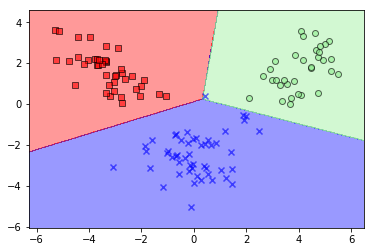

In [141]:
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)


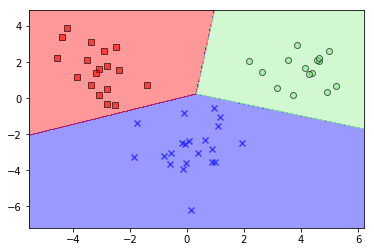

In [142]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)

In [174]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    sq_dists = pdist(X, 'sqeuclidean')
    mat_sq_dists = squareform(sq_dists)
    K = exp(-gamma * mat_sq_dists)
    # 中心化
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    # 固有値の取得
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]
    
    # 上位ｋ個のベクトルを収集
    alphas = np.column_stack((eigvecs[:, i] for i in range(n_components)))
    
    # 対応する固有値を取得
    lambdas = [eigvals[i] for i in range(n_components)]
    
    return alphas, lambdas

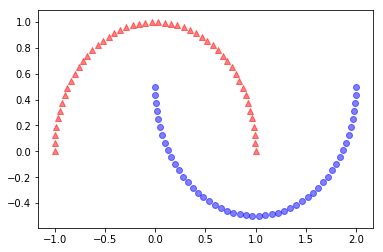

In [151]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)


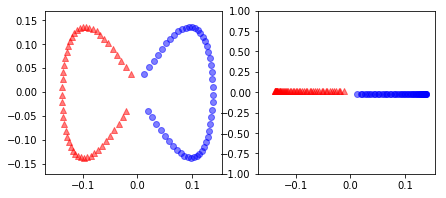

In [167]:
from matplotlib.ticker import FormatStrFormatter

X_kcpa = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
ax[0].scatter(X_kcpa[y==0, 0], X_kpca[y==0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kcpa[y==1, 0], X_kpca[y==1, 1],
              color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kcpa[y==0, 0], np.zeros((50,1))+0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kcpa[y==1, 0], np.zeros((50,1))-0.02,
              color='blue', marker='o', alpha=0.5)
ax[1].set_ylim([-1,1])
plt.show()

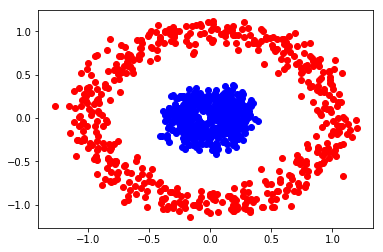

In [168]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red')
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue')

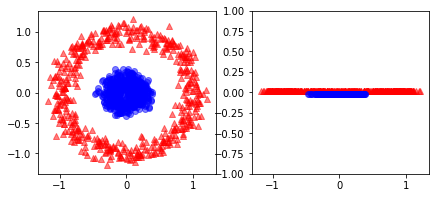

In [170]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1],
              color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_spca[y==0, 0], np.zeros((500,1))+0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((500,1))-0.02,
              color='blue', marker='o', alpha=0.5)
ax[1].set_ylim([-1,1])
plt.show()

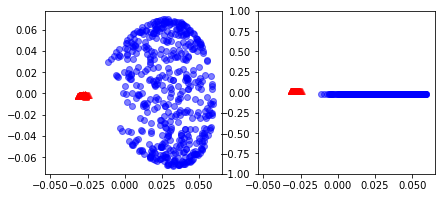

In [171]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
              color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((500,1))+0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((500,1))-0.02,
              color='blue', marker='o', alpha=0.5)
ax[1].set_ylim([-1,1])
plt.show()

In [175]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

In [176]:
x_new = X[25]
x_new

array([1.8713, 0.0093])

In [177]:
x_prof = alphas[25]
x_prof

array([0.0788])

In [178]:
from sklearn.decomposition import KernelPCA
X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

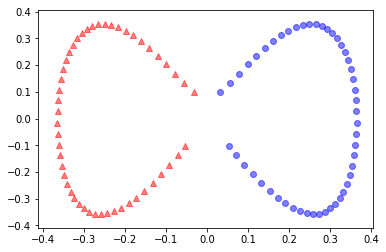

In [179]:
plt.scatter(X_skernpca[y==0, 0], X_skernpca[y==0, 1],
              color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1, 1],
              color='blue', marker='o', alpha=0.5)